### Count queries
The most basic statistical tool, a count query, returns an estimate of the number of individual records in the data satisfying a specific predicate. Differentially private answers to count queries
can be obtained through the addition of random noise.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io

This notebook explores one disclosure avoidance technique that injects Laplacian-distributed noise to tabulated the Public Use Microdata Sample(PUMS) data. First, let's download the PUMS data and read it into a pandas dataframe.

In [5]:
r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_ppa.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract('psam_p42.csv')
pa = pd.read_csv("psam_p42.csv")

Next, lets filter the data to contain only relevant variables and people.  
In our example we will focus on educational attainment and race for all person above the age of 18.   
For variable defintions see:
https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.pdf

In [6]:
#Filtering geographic location, race, educational attainment, total income in past 12 months and age for all 18+ PA persons
new_pa = pa.query("AGEP>=18").filter(items=['PUMA','RAC1P','RAC2P','SCHL','WAGP','PINCP','AGEP'])
new_pa.head()

,PUMA,RAC1P,RAC2P,SCHL,WAGP,PINCP,AGEP
0,1300,1,1,16.0,0.0,7300.0,83
1,1300,1,1,21.0,0.0,11000.0,69
2,3401,1,1,22.0,0.0,75200.0,68
3,3401,1,1,21.0,0.0,36400.0,67
4,4002,1,1,19.0,0.0,2600.0,47


In [7]:
#create a table showing total count of educational attaninment of adults in PA by race. 
pivot_pa = pd.pivot_table(new_pa,
                              index='RAC1P',
                              columns='SCHL',
                              values='PINCP',
                              aggfunc=np.size,
                              margins=True)

pivot_pa.columns = ['No schooling','preschool','K','Grade 1','Grade 2','Grade 3','Grade 4','Grade 5','Grade 6','Grade 7','Grade 8'
                        ,'Grade 9','Grade 10','Grade 11','Grade 12-no diploma','HS diploma','GED','some college','1+ year college','Associate',
                        'Bachelor','Master','Professional','Doctorate','ALL']
#TODO: rename columns for clarity.
pivot_pa.head(10)


,No schooling,preschool,K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,...,HS diploma,GED,some college,1+ year college,Associate,Bachelor,Master,Professional,Doctorate,ALL
RAC1P,,,,,,,,,,,,,,,,,,,,,
1,3749.0,54.0,48.0,53.0,73.0,230.0,192.0,301.0,760.0,880.0,...,155828.0,17058.0,28869.0,52859.0,37029.0,76093.0,33779.0,7413.0,5328.0,456843.0
2,633.0,10.0,12.0,9.0,20.0,39.0,27.0,58.0,116.0,118.0,...,10704.0,2521.0,2696.0,6011.0,2318.0,3326.0,1607.0,271.0,234.0,35469.0
3,10.0,1.0,1.0,NaN,1.0,2.0,NaN,1.0,16.0,4.0,...,144.0,36.0,40.0,75.0,33.0,68.0,37.0,4.0,6.0,543.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,2.0,1.0,2.0,NaN,NaN,2.0,1.0,NaN,1.0,10.0
5,10.0,NaN,NaN,2.0,4.0,2.0,4.0,NaN,3.0,5.0,...,69.0,17.0,19.0,36.0,19.0,22.0,3.0,5.0,1.0,268.0
6,571.0,1.0,4.0,9.0,21.0,32.0,35.0,65.0,116.0,53.0,...,1847.0,163.0,583.0,1363.0,515.0,2982.0,1834.0,666.0,695.0,12446.0
7,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0,10.0,10.0,15.0,6.0,16.0,12.0,1.0,2.0,122.0
8,225.0,2.0,2.0,12.0,14.0,45.0,34.0,53.0,129.0,60.0,...,1397.0,329.0,329.0,588.0,267.0,356.0,117.0,33.0,25.0,5044.0
9,77.0,4.0,1.0,3.0,4.0,9.0,11.0,13.0,34.0,21.0,...,1415.0,337.0,531.0,1135.0,456.0,877.0,348.0,107.0,67.0,6079.0


**The Laplace Mechanism**
The Laplace mechanism adds Laplacian-distributed noise to a function.

Notice that the `laplace_mech()` consumes a parameter `epsilon`. We refer to this quantity as the privacy loss of the mechanism and is part of the most central definition in the field of differential privacy: ε-differential privacy. By tuning epsilon, we control the noisiness of our noisy counting. Choosing a smaller epsilon produces noisier results and better privacy guarantees. 

Generally, the `sensitivity` of a function is the largest possible difference that one row can have on the result of that function, for any dataset. The larger the sensitivity, the noisier the answer will be. Calculating the sensitivity for an arbitrary function can be difficult, but we know that any counting query has a sensitivity of 1, because adding or removing a single row from any dataset will change the count by at most 1.

If S is the sensitivity of a function f, a measure of how revealing the function might be, then adding Laplace noise with scale S/ε preserves ε-differential privacy.

In [8]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

### Quality Metrics

While the trade-off between statistical accuracy and privacy loss is at the heart of differential privacy, there are many metrics for assessing the quality of a published dataset. One approach is to calculate the L1 error between the true data (i.e. without disclosure limitation) and the privatized data.

**The L1 Norm** In this simple scenario involving the Laplace Mechanism, the L1 error is a natural metric. The L1 norm is basically minimizing the sum of the absolute differences between the target value and the estimated values. This is a coarse measure: a disclosure limited product with a high L1 compared to the same product without disclosure limitation may still be very accurate for its intended use. 

In [9]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n

### Trade-off Between Privacy Loss and Accuracy

When submitting to the DRB, the practitioner prepares a set of graphs that show the trade-off between privacy loss (ϵ) and accuracy. DRB officials then picks a value of ϵ that allows for sufficient accuracy. Officials most often estimate with epsilon values between 1 and 9.

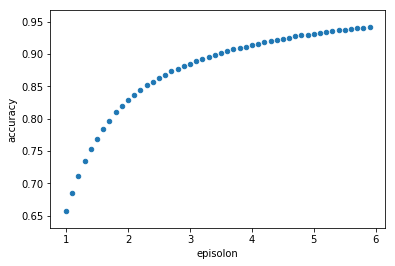

In [10]:
orig_arr = pd.DataFrame(pivot_pa.fillna(0))
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,6.0,.1)
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()

### Postprocessing

Postprocessing the output of a DP mechanism does not degrade privacy. In this case, we want to round any negative counts to zero.

In [11]:
noisy_counts = laplace_mech(orig_arr, 3)
noisy_counts

,No schooling,preschool,K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,...,HS diploma,GED,some college,1+ year college,Associate,Bachelor,Master,Professional,Doctorate,ALL
RAC1P,,,,,,,,,,,,,,,,,,,,,
1,3748.358527,54.134186,48.436086,52.672722,73.212851,229.897581,191.816324,300.964336,760.210273,879.644656,...,155828.168061,17057.321127,28869.161696,52859.332173,37028.813036,76093.072767,33779.777775,7413.817884,5327.385479,456842.001951
2,632.974939,10.418182,11.883085,10.634904,20.596102,39.201124,27.099599,57.205088,115.344904,118.873109,...,10704.099634,2521.198730,2696.608084,6011.062883,2318.127586,3325.269032,1607.018916,271.077124,234.218162,35468.706974
3,9.546838,1.235053,0.933518,-0.020388,0.588709,1.911098,-0.111871,1.480445,16.016029,2.993064,...,143.523594,36.494389,39.541537,75.033993,32.988946,67.387128,36.816375,3.661083,5.759452,543.340148
4,-0.079144,0.111350,-0.642422,-0.515788,-0.654761,-0.126433,0.179355,-0.222142,1.405343,0.235955,...,2.229339,1.582216,2.246327,0.106457,-0.163451,2.249619,1.400104,-0.057664,0.821468,9.840861
5,10.206998,0.289895,0.574590,1.370734,4.258548,1.751740,4.164432,0.066191,2.809893,5.258145,...,69.623944,15.963988,19.807838,36.005663,19.280569,22.309814,2.559241,5.094565,1.283711,268.254114
6,571.339646,0.866842,4.804685,8.781167,20.417228,32.032695,34.560559,65.062183,115.725436,53.656944,...,1846.808703,163.734593,582.849094,1363.004398,515.327056,2983.155577,1833.735839,665.936735,695.098786,12445.770778
7,4.968150,0.301750,-0.448018,-0.093293,-0.559060,-0.986493,-0.003805,0.360371,-0.489854,-0.226959,...,35.171135,10.052146,9.829040,15.346865,6.393749,16.230978,12.252435,0.457376,2.029188,121.949287
8,225.052555,2.369194,1.401806,11.986795,13.996728,45.648157,34.576652,53.043341,129.408127,60.493163,...,1397.003927,329.652954,328.948570,588.129080,266.991275,356.166125,116.828003,33.219268,24.780615,5043.805961
9,76.825338,3.630306,0.806618,2.903627,4.356209,8.871434,10.873316,12.966134,34.202305,20.866503,...,1415.336115,337.009391,530.991672,1134.544033,457.757167,877.474358,348.476040,106.098692,66.722166,6078.553111


Rounding helper function 

In [18]:
def rounder(x):
    if x < 0:
        return 0 
    else:
        return round(x)

In [19]:
#Apply rounder to every cell in new noisy output
rounded_counts = noisy_counts.applymap(rounder)

In [20]:
rounded_counts

,No schooling,preschool,K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,...,HS diploma,GED,some college,1+ year college,Associate,Bachelor,Master,Professional,Doctorate,ALL
RAC1P,,,,,,,,,,,,,,,,,,,,,
1,3748,54,48,53,73,230,192,301,760,880,...,155828,17057,28869,52859,37029,76093,33780,7414,5327,456842
2,633,10,12,11,21,39,27,57,115,119,...,10704,2521,2697,6011,2318,3325,1607,271,234,35469
3,10,1,1,0,1,2,0,1,16,3,...,144,36,40,75,33,67,37,4,6,543
4,0,0,0,0,0,0,0,0,1,0,...,2,2,2,0,0,2,1,0,1,10
5,10,0,1,1,4,2,4,0,3,5,...,70,16,20,36,19,22,3,5,1,268
6,571,1,5,9,20,32,35,65,116,54,...,1847,164,583,1363,515,2983,1834,666,695,12446
7,5,0,0,0,0,0,0,0,0,0,...,35,10,10,15,6,16,12,0,2,122
8,225,2,1,12,14,46,35,53,129,60,...,1397,330,329,588,267,356,117,33,25,5044
9,77,4,1,3,4,9,11,13,34,21,...,1415,337,531,1135,458,877,348,106,67,6079


### Another way to get DP counts

In [21]:
#TODO: make individual tables for persons of each broad (RAC1P) racial catagory and use randomized response to show a different technique 